## Tutotial 10 - Transformers for Vision, Representation Learning with Transformers

In this tutorial we will first get familiar with a popular Transformer architecture for visual modality - ViT. 
Then we will play with representations learned by one specific strong pretrained ViT-based model - DINOv2.

In [25]:
from typing import Tuple
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from einops import rearrange

from training import train

## ViT or Vision Transformer

Following the success of Transformers for language ViTs were [shortly proposed](https://arxiv.org/abs/2010.11929) to adapt the attention-based architecture for images. 
Nowadays ViTs slowly take over all the vision domains, from classification to generation.

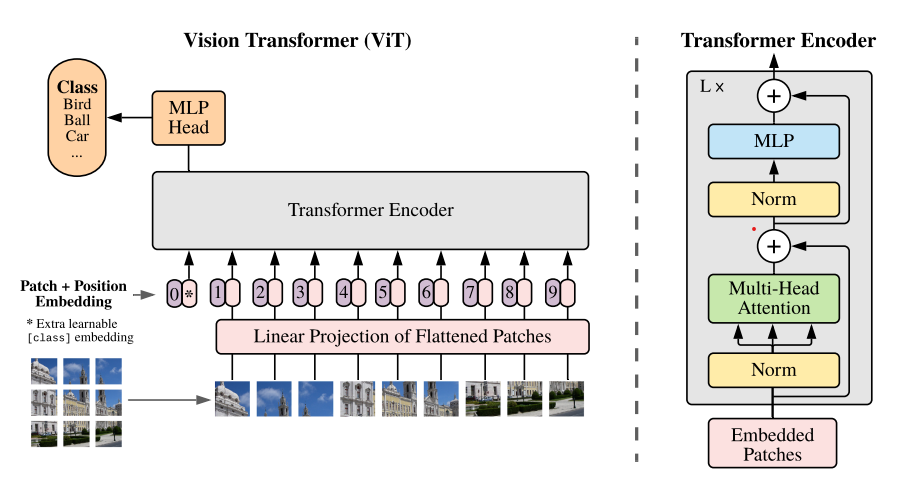

The image is tiled into patches on a fixed grid (e.g. 16 x 16). Each tile is linearly projected to an embedding space. Those embeddings or image tokens are augmented with some position encodings and fed to a transformer network. Optionally an additional special token [class] can be used to gather information for a downstream task, e.g. classification.

## Implement the ViT and train it on CIFAR10

In [26]:
class ViTBlock(nn.Module):
    def __init__(self, embed_dim: int, fc_dim: int, num_heads: int, dropout: float):
        super(ViTBlock, self).__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, fc_dim),
            nn.GELU(),
            nn.Linear(fc_dim, embed_dim)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param x: [b n d]
        """
        nx = self.norm1(x)
        attn_out, attn_weights = self.attn(nx, nx, nx)
        x = x + attn_out
        x = x + self.fc(self.norm2(x))

        return x, attn_weights


class ViT(nn.Module):
    def __init__(self, tile_size: int, num_layers: int, embed_dim: int, 
                 num_heads: int, dropout: float, max_num_tokens=500):
        super(ViT, self).__init__()

        self.tile_size = tile_size
        self.embed_dim = embed_dim
        self.tile = nn.Conv2d(3, embed_dim, kernel_size=tile_size, stride=tile_size, padding=0)
        self.cls_token = nn.Parameter(torch.randn([1, 1, embed_dim]), requires_grad=True)
        self.position_encoding = nn.Parameter(torch.randn([1, max_num_tokens, embed_dim]), requires_grad=True)
        self.main_blocks = nn.ModuleList([ViTBlock(embed_dim, 4 * embed_dim, num_heads, dropout) for _ in range(num_layers)])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        :param x: [b c h w]
        """
        b = x.size(0)
        th = x.size(2) // self.tile_size
        
        x = self.tile(x)
        x = rearrange(x, "b c h w -> b (h w) c")

        x = torch.cat([self.cls_token.expand(b, -1, -1), x], dim=1)
        x = x + self.position_encoding[:, :x.size(1)]

        for block in self.main_blocks:
            x, attn_map = block(x)

        out_cls = x[:, 0]
        out_sp = rearrange(x[:, 1:], "b (h w) c -> b c h w", h=th)

        attn_map = rearrange(attn_map[:, 0, 1:], "b (h w) -> b h w", h=th)
        
        return out_cls, out_sp, attn_map


class Model(nn.Module):
    def __init__(self, backbone: nn.Module, out_dim: int):
        super(Model, self).__init__()

        self.backbone = backbone
        self.out = nn.Sequential(
            nn.LayerNorm(self.backbone.embed_dim),
            nn.Linear(self.backbone.embed_dim, out_dim)
        )

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor):
        """
        :param x: [b c h w]
        """

        feats = self.backbone(x)
        out = self.out(feats[0])

        return out, *feats

Here we have implemented the ViT block using `nn.MultiheadAttention` class, as it also provides a simple way to get the attention maps of the layer. However, it is very usefull to try and implement the multihead attention mechanism on you own (a similar attention mechanism was implemented on the previoius tutorial). Try this later and compare the results with the current implementation.

Another direction is the opposite, to simplify things. PyTorch actually already has the building block for implementing Transformers. Check the `nn.TransformerEncoderLayer` for self-attention and the `nn.TransformerDecoderLayer` for cross-attention.

Now let's define the dataset. We will use CIFAR10 here.

In [6]:
tr = T.Compose([
    T.ToTensor(),
    T.Resize((112, 112), antialias=True),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    T.RandomHorizontalFlip(p=0.5),
])
dataset = torchvision.datasets.CIFAR10(root="data", train=True, transform=tr, download=True)

Files already downloaded and verified


All that remains is to define the model and train it. To save some time, in this tutorial we will train the models for 1 epoch only. Later you may try training for longer.

In [7]:
device = torch.device("cuda:0")
vit = ViT(tile_size=14, num_layers=6, embed_dim=256, num_heads=8, dropout=0.1)
model = Model(backbone=vit, out_dim=10)
train(model, dataset, num_epochs=1, batch_size=256, learning_rate=0.0001, val_size=0.1, device=device)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Let's visualize some attention maps of the [class] token from the last layer on the training images.

In [8]:
def to_image(image):
    return ((1 + torch.clamp(image, -1, 1).permute(1, 2, 0)) * 127.5).to(torch.uint8)

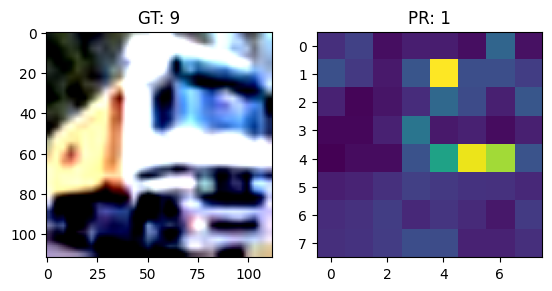

In [23]:
image, label = dataset[1]

with torch.no_grad():
    model.eval()
    model.to(device)
    out = model(image.unsqueeze(0).to(device))
    out = [o.cpu() for o in out]

ax = plt.subplot(1, 2, 1)
ax.imshow(to_image(image))
ax.set_title(f"GT: {label}")

ax = plt.subplot(1, 2, 2)
ax.imshow(out[3][0])
ax.set_title(f"PR: {out[0].argmax().item()}")

plt.show()

## Transfer Learning

For training efficiency and improving results on small datasets, it is sometimes good to transfer knowledge from another model that was trained on a large amount of data.

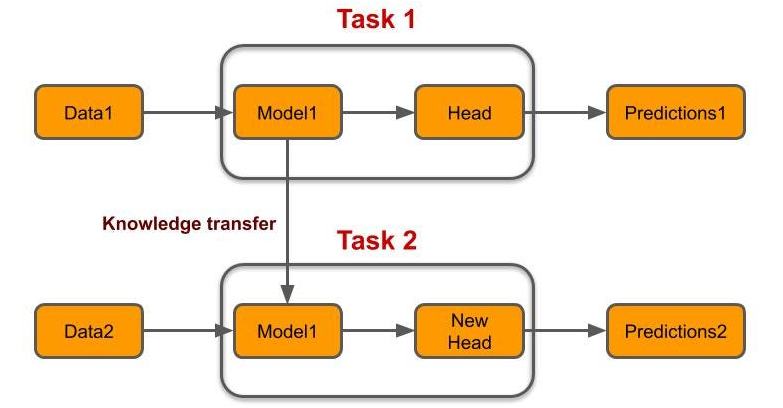

## DINOv2: great features for vision-based downstream tasks

DINOv2 is a ViT that was trained in a self-supervised manner (without labels) on a large carefully currated dataset.
It is proven to have learned very useful image representation.

Replace the backbone with DINOv2 and train only the linear classifier on top.

In [27]:
class DINOv2Backbone(nn.Module):
    def __init__(self):
        super(DINOv2Backbone, self).__init__()
        
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.embed_dim = self.dino.embed_dim
    
    def forward(self, x: torch.Tensor, scale: int = 1) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param x: [b c h w]
        """

        # DINOv2's tile size is 14x14, so the input image resolution has to be divisble by 14
        # 224 was the native training resolution, so it is better to stick to it
        x = F.interpolate(x, size=(scale * 224, scale * 224), mode="bilinear", align_corners=False)
        out = self.dino.get_intermediate_layers(x, n=1, reshape=True, return_class_token=True)[0]

        return out[1], out[0]

Let's train the model as before.

In [28]:
dinov2_vits14 = DINOv2Backbone()
model_dino = Model(dinov2_vits14, out_dim=10)
model_dino.freeze_backbone()
train(model_dino, dataset, num_epochs=1, batch_size=256, learning_rate=0.0001, val_size=0.1, device=device)

Using cache found in /home/ad20n980/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Notice that in one epoch we have reached the accuracy of the other model trained for many more epochs. Transfer learning is very efficient if the features are good.

Let's visualize some attention maps of DINOv2.

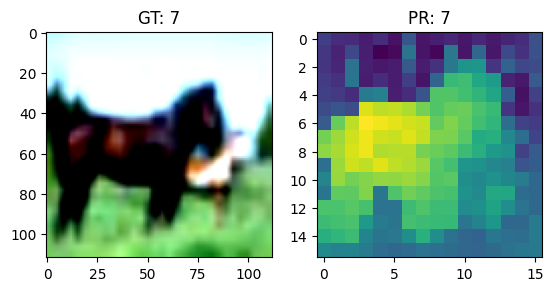

In [39]:
image, label = dataset[12]

with torch.no_grad():
    model_dino.eval()
    model_dino.to(device)
    out = model_dino(image.unsqueeze(0).to(device))
    out = [o.cpu() for o in out]

ax = plt.subplot(1, 2, 1)
ax.imshow(to_image(image))
ax.set_title(f"GT: {label}")

ax = plt.subplot(1, 2, 2)
attn_map = (out[1].unsqueeze(2).unsqueeze(3) * out[2]).sum(1)[0]
ax.imshow(attn_map)
ax.set_title(f"PR: {out[0].argmax().item()}")

plt.show()

It seems that DINOv2's attention maps capture the central object really well. Can we use this capability?

## Segmentation with DINOv2 features

It turns out that the features are so good that one does not even need to fine-tune or transfer the model for certain tasks. E.g. one can get relatively good but coarse segmentations for free, in a so called zero-shot manner.

Calculate the features of an image and fit a single component PCA to it. Build the segmentation mask based on the sign of the projections of the features on the first principal component.

In [40]:
from sklearn.decomposition import PCA

In [41]:
@torch.no_grad()
def segment_with_dinov2(
        images: torch.Tensor,
        dino: nn.Module, 
        scale: int = 1,
        device: torch.device = torch.device("cpu")) -> torch.Tensor:
    """
    :param images: [b c h w]
    :param dino: DINOv2 instance
    :param sclae: resolution scale
    :param device: device to use
    :return: segmentation maps [b h w]
    """

    dino.to(device)
    dino.eval()
    images = images.to(device)
    
    features = dino(images, scale=scale)[1]

    b, _, h, _ = features.shape
    features = rearrange(features.cpu(), "b c h w -> (b h w) c")
    
    pca = PCA(n_components=1)
    first_component = torch.from_numpy(pca.fit_transform(features))
    first_component = rearrange(first_component, "(b h w) 1 -> b h w", b=b, h=h)

    segmentation = (first_component > 0).to(torch.float32)
    return segmentation

Test the method on the example images of cars.

In [42]:
# ims = [
#     Image.open("car_1.png"),
#     Image.open("car_2.png")
# ]
ims = [
    Image.open("bird_1.jpeg"),
    Image.open("bird_2.jpeg"),
    Image.open("bird_3.jpeg"),
]

tr_dino = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224), antialias=True),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

ims = [tr_dino(im) for im in ims]
images = torch.stack(ims)

In [44]:
segments = segment_with_dinov2(images, dinov2_vits14, scale=4, device=device)

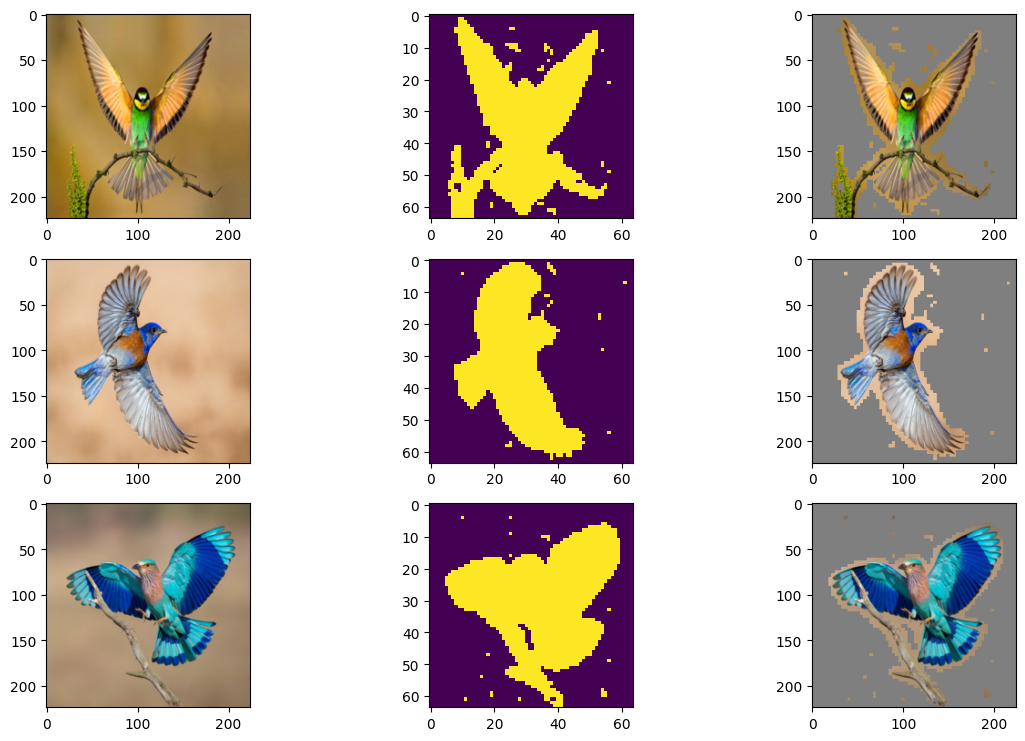

In [45]:
plt.figure(figsize=(14, 3 * len(images)))

masked_images = []
for i, (im, seg) in enumerate(zip(images, segments)):
    ax = plt.subplot(len(images), 3, i * 3 + 1)
    ax.imshow(to_image(im))

    ax = plt.subplot(len(images), 3, i * 3 + 2)
    ax.imshow(seg)

    ax = plt.subplot(len(images), 3, i * 3 + 3)
    masked = im * F.interpolate(seg.unsqueeze(0).unsqueeze(1), size=(im.size(1), im.size(2)))
    masked_images.append(masked[0])
    ax.imshow(to_image(masked_images[-1]))
masked_images = torch.stack(masked_images)

## Correspondence with DINOv2 features

To visualize the features it is often useful to calculate the first 3 PCA components of the object features and treat them as images.

In [46]:
@torch.no_grad()
def dinov2_to_rgb(
        images: torch.Tensor,
        masks: torch.Tensor,
        dino: nn.Module, 
        scale: int = 1,
        device: torch.device = torch.device("cpu")) -> torch.Tensor:
    """
    :param images: [b c h w]
    :param masks: [b h w]
    :param dino: DINOv2 instance
    :param scale: resolution scale
    :param device: device to use
    :return: segmentation maps [b h w]
    """

    dino.to(device)
    dino.eval()
    images = images.to(device)
    
    features = dino(images, scale=scale)[1]
    
    b, _, h, _ = features.shape
    features = rearrange(features.cpu(), "b c h w -> (b h w) c")
    masks_r = rearrange(masks.cpu(), "b h w -> (b h w)")
    selected_features = features[masks_r.nonzero()[:, 0]]

    pca = PCA(n_components=3)
    pca.fit(selected_features)
    components = torch.from_numpy(pca.transform(features))
    components = rearrange(components, "(b h w) c -> b c h w", b=b, h=h)
    components = components * masks.unsqueeze(1)
    
    return components

In [47]:
rgb_features = dinov2_to_rgb(images, segments, dinov2_vits14, scale=4, device=device)

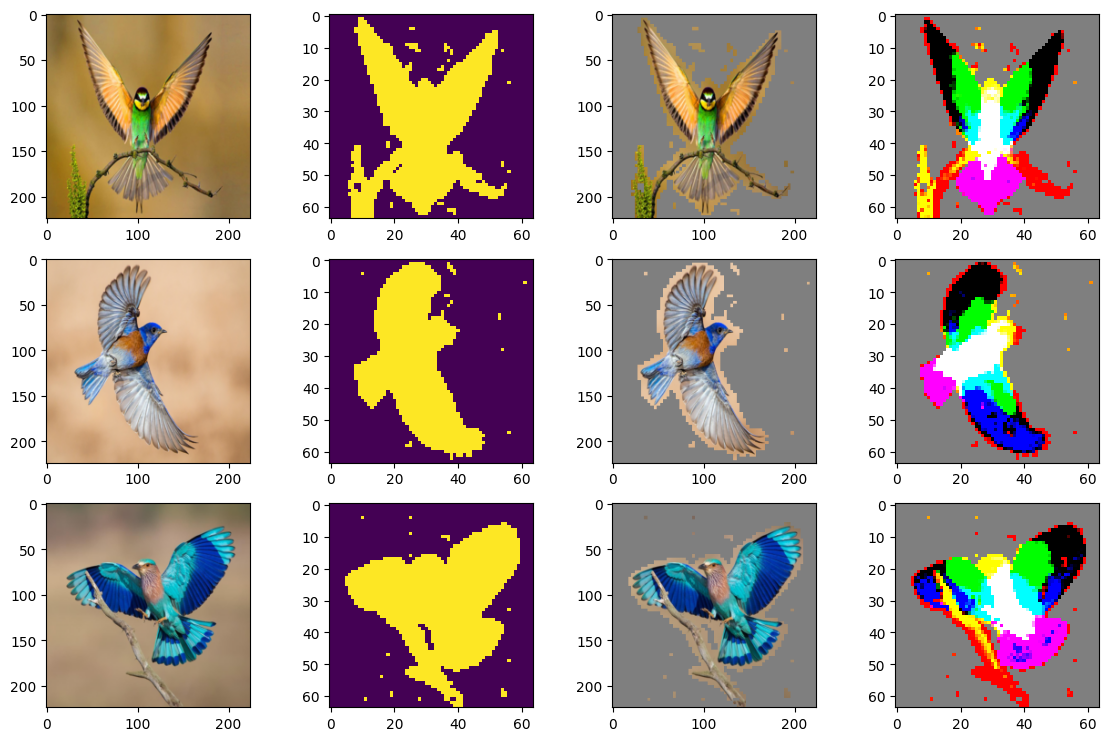

In [48]:
plt.figure(figsize=(14, 3 * len(images)))
for i, (im, seg, masked, features) in enumerate(zip(images, segments, masked_images, rgb_features)):
    ax = plt.subplot(len(images), 4, i * 4 + 1)
    ax.imshow(to_image(im))

    ax = plt.subplot(len(images), 4, i * 4 + 2)
    ax.imshow(seg)

    ax = plt.subplot(len(images), 4, i * 4 + 3)
    ax.imshow(to_image(masked))

    ax = plt.subplot(len(images), 4, i * 4 + 4)
    ax.imshow(to_image(features))
    

Notice that different parts of the objects that are semantically close to each other are closer in the PCA space.